In [1]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from torch.nn import functional as F
from torch.optim.lr_scheduler import LambdaLR

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Code I

## 1
First, t is embedded into a high-dimensional space using Guassian Fourier features before being passed through a linear layer and the swish activation function.

Layers h1-h4 are the encoding layers. In each step of the encoding layers, the input is passed though a convolutional layer with progressively smaller dimensions and more channels. Each layer adds a dense projection of the embedded time. Finally, GroupNorm and the swish activation function are applied after each step.

Next is the decoding layers. In each step of the decoding, the transposed convolutions (of the encoding layer) is applied. h = self.tconv-(torch.cat([h, h-], dim=1)) adds encoder features at each step.

The final transposed convolution is a single-channel image.

In [2]:
#@title Defining a time-dependent score-based model (double click to expand or collapse)

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

  def forward(self, x):
    if x.dim() == 1:
        x = x[:, None]

    x_proj = x * self.W * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)

  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, channels=[32, 64, 128, 256], embed_dim=256, group_num=4):

    super().__init__()

    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))

    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(group_num, num_channels=channels[0])

    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(group_num, num_channels=channels[1])

    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(group_num, num_channels=channels[2])

    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(group_num, num_channels=channels[3])

    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(group_num, num_channels=channels[2])

    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(group_num, num_channels=channels[1])

    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(group_num, num_channels=channels[0])

    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)

    self.rho0 = nn.Parameter(torch.tensor(1.0))
    self.rho1 = nn.Parameter(torch.tensor(0.5))

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.embed(t))

    h1 = self.conv1(x) # ...
    h1 += self.dense1(embed) #...
    h1 = self.gnorm1(h1) # ...
    h1 = self.act(h1) # ...
    h2 = self.conv2(h1) # ...
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    h = self.tconv4(h4) # ...
    h += self.dense5(embed) # ...
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1)) # ...
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    mu = self.rho0 * (x - self.rho1 * h)

    return mu

## 3

In [3]:
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return betas.clamp(0.0001, 0.9999)

class Diffusion(nn.Module):
    def __init__(self, model, n_steps, device, min_beta=0.0001, max_beta=0.02):
        # Store beta, alpha and \bar alpha.
        super().__init__()
        self.model = model
        self.n_steps = n_steps
        self.device = device

        # defining beta and alpha
        # self.beta = torch.linspace(min_beta, max_beta, n_steps).to(device)
        self.beta = cosine_beta_schedule(n_steps).to(device)    # experimenting with cosine beta schedule
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0).to(device)

    def forward_process(self, x0, t):
        # Sample x_{t-1},x_t given x_0
        alpha_bar_tm1 = self.alpha_bar[t - 1].view(-1, 1, 1, 1)
        alpha_t = self.alpha[t].view(-1, 1, 1, 1)
        alpha_bar_t = self.alpha_bar[t].view(-1, 1, 1, 1)

        noise1 = torch.randn_like(x0)
        x_tm1 = torch.sqrt(alpha_bar_tm1) * x0 + torch.sqrt(1 - alpha_bar_tm1) * noise1

        noise2 = torch.randn_like(x0)
        x_t = torch.sqrt(alpha_t) * x_tm1 + torch.sqrt(1 - alpha_t) * noise2
        return x_tm1, x_t

    def predict_next(self, x_t, t):
        # Compute mu(xt,t)
        return self.model(x_t, t)

    def sample_xt_given_x0(self, x0, t):
        alpha_bar_t = self.alpha_bar[t].view(-1, 1, 1, 1)
        noise = torch.randn_like(x0)
        x_t = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise
        return x_t


## 4

In [4]:
def compute_loss(diffusion, x0):
    B = x0.shape[0]
    device = x0.device
    T = diffusion.n_steps
    t = torch.randint(1, T, (B,), device=device)

    x_tm1, x_t = diffusion.forward_process(x0, t)
    mu = diffusion.predict_next(x_t, t)
    alpha_t = diffusion.alpha[t].view(-1, 1, 1, 1)
    coeff = (1.0 / (2.0 * (1.0 - alpha_t))).view(B)
    loss = (coeff * ((x_tm1 - mu) ** 2).mean(dim=(1, 2, 3))).mean()

    return loss

def compute_adjusted_loss(diffusion, x0, M=4):
    B = x0.shape[0]
    device = x0.device
    T = diffusion.n_steps
    t = torch.randint(1, T, (B,), device=device)

    alpha_t = diffusion.alpha[t].view(B, 1, 1, 1)
    alpha_bar_tm1 = diffusion.alpha_bar[t - 1].view(B, 1, 1, 1)
    coeff = (1.0 / (2.0 * (1.0 - alpha_t))).view(B, 1, 1, 1)

    noise1 = torch.randn_like(x0)
    x_tm1 = torch.sqrt(alpha_bar_tm1) * x0 + torch.sqrt(1 - alpha_bar_tm1) * noise1

    total_loss = torch.zeros(B, device=device)
    for _ in range(M):
        noise2 = torch.randn_like(x0)
        x_t = torch.sqrt(alpha_t) * x_tm1 + torch.sqrt(1 - alpha_t) * noise2

        mu = diffusion.predict_next(x_t, t)
        loss = coeff * ((x_tm1 - mu) ** 2)
        total_loss += loss.view(B, -1).mean(dim=1)

    return (total_loss / M).mean()

## 5

In order to reduce the variance of the estimate, we could sample multiple x_t for each x_0 and x_tm1. In other words, for each x_0, we first sample one x_tm1, then sample multiple x_t, and average the loss over the number of sampled x_t.

## 6

In [5]:
def train(model, diffusion, train_data, optimizer, loss_fn, num_epochs=60, batch_size=100):
    device = diffusion.device
    train_dataset = torch.utils.data.TensorDataset(train_data)
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    scheduler = LambdaLR(optimizer, lr_lambda=[
        lambda epoch: 1.0,
        lambda epoch: 0.1 ** (epoch // 20)
    ])

    for epoch in range(1, num_epochs+1):
        epoch_loss = 0.0

        # freeze rho1 for the first 10 epochs, to let the model learn mu before trying to learn rho1
        # otherwise, the model tends to decay rho1 to 0 and ignore the predicted mu
        model.rho1.requires_grad = False if epoch <= 10 else True

        for batch in loader:
            x0 = batch[0].to(device)

            optimizer.zero_grad()
            loss = loss_fn(diffusion, x0)

            # after rho1 is unfrozen, I added a regularization term to keep rho1 within a reasonable range
            if epoch > 10:
                loss += 0.01 * (0.5 - diffusion.model.rho1)**2

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            model.rho0.data.clamp_(0, 1.0)
            model.rho1.data.clamp_(0.2, 0.6)

        scheduler.step()

        current_rho_lr = scheduler.get_last_lr()[1]
        print(f"Epoch {epoch}, Loss: {epoch_loss / len(loader):.4f}, rho_lr: {current_rho_lr:.6f}")

        avg_loss = epoch_loss / len(loader)
        print(f"rho0: {model.rho0.item():.4f}, rho1: {model.rho1.item():.4f}")

    return avg_loss


def evaluate_model(model, diffusion, x_val, loss_fn, batch_size=100):
    with torch.no_grad():
        model.eval()
        total_loss = 0.0
        for i in range(0, x_val.shape[0], batch_size):
            x0 = x_val[i:i+batch_size].to(diffusion.device)
            total_loss += loss_fn(diffusion, x0).item()
        return total_loss / (x_val.shape[0] // batch_size)


def get_mnist():
    train_dataset = datasets.MNIST(root='./data', train=True, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True)

    full_data = torch.cat([train_dataset.data, test_dataset.data], dim=0).float() / 255.0
    full_data = full_data.unsqueeze(1)

    train_data = full_data[0:50000].to(device)
    val_data   = full_data[50000:60000].to(device)
    test_data  = full_data[60000:70000].to(device)

    return train_data, val_data, test_data

In [6]:
train_data, val_data, test_data = get_mnist()

100%|██████████| 9.91M/9.91M [00:00<00:00, 40.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.12MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.69MB/s]


In [ ]:
default_losses = []
adjusted_losses = []
for _ in range(20):
    indices = torch.randint(0, train_data.shape[0], (1000,))
    subset = train_data[indices]

    model_default = ScoreNet()
    model_default.to(device)
    diffusion_default = Diffusion(model_default, n_steps=200, device=device, min_beta=1e-4, max_beta=0.01)

    rho_params = [model_default.rho0, model_default.rho1]
    rho_ids = set(id(p) for p in rho_params)
    base_params = [p for p in model_default.parameters() if id(p) not in rho_ids]
    optimizer_default = torch.optim.Adam([
        {"params": base_params, "lr": 0.001},
        {"params": rho_params, "lr": 0.2}
    ])

    train(model_default, diffusion_default, subset, optimizer_default, compute_loss)
    default_loss = evaluate_model(model_default, diffusion_default, val_data, compute_loss)
    default_losses.append(default_loss)

    model_adjusted = ScoreNet()
    model_adjusted.to(device)
    diffusion_adjusted = Diffusion(model_adjusted, n_steps=200, device=device, min_beta=1e-4, max_beta=0.01)

    rho_params = [model_adjusted.rho0, model_adjusted.rho1]
    rho_ids = set(id(p) for p in rho_params)
    base_params = [p for p in model_adjusted.parameters() if id(p) not in rho_ids]
    optimizer_adjusted = torch.optim.Adam([
        {"params": base_params, "lr": 0.001},
        {"params": rho_params, "lr": 0.2}
    ])

    train(model_adjusted, diffusion_adjusted, subset, optimizer_adjusted, compute_adjusted_loss)
    adjusted_loss = evaluate_model(model_adjusted, diffusion_adjusted, val_data, compute_adjusted_loss)
    adjusted_losses.append(adjusted_loss)

Epoch 1, Loss: 35.7769, rho_lr: 0.200000
rho0: 0.0032, rho1: 0.5000
Epoch 2, Loss: 14.0353, rho_lr: 0.200000
rho0: 0.2185, rho1: 0.5000
Epoch 3, Loss: 7.3162, rho_lr: 0.200000
rho0: 0.3023, rho1: 0.5000
Epoch 4, Loss: 4.5726, rho_lr: 0.200000
rho0: 0.3639, rho1: 0.5000
Epoch 5, Loss: 3.1346, rho_lr: 0.200000
rho0: 0.3578, rho1: 0.5000
Epoch 6, Loss: 2.6784, rho_lr: 0.200000
rho0: 0.3654, rho1: 0.5000
Epoch 7, Loss: 2.2105, rho_lr: 0.200000
rho0: 0.3692, rho1: 0.5000
Epoch 8, Loss: 2.0247, rho_lr: 0.200000
rho0: 0.3652, rho1: 0.5000
Epoch 9, Loss: 1.8523, rho_lr: 0.200000
rho0: 0.3630, rho1: 0.5000
Epoch 10, Loss: 1.7979, rho_lr: 0.200000
rho0: 0.3674, rho1: 0.5000
Epoch 11, Loss: 1.9509, rho_lr: 0.200000
rho0: 0.4288, rho1: 0.3971
Epoch 12, Loss: 1.4428, rho_lr: 0.200000
rho0: 0.5282, rho1: 0.2710
Epoch 13, Loss: 1.0103, rho_lr: 0.200000
rho0: 0.6119, rho1: 0.2000
Epoch 14, Loss: 0.9621, rho_lr: 0.200000
rho0: 0.6026, rho1: 0.2000
Epoch 15, Loss: 0.9164, rho_lr: 0.200000
rho0: 0.6020, 

In [ ]:
print(np.std(default_losses))
print(np.std(adjusted_losses))

0.05590826899283577
0.03608545019663142


The variability of the loss over the 20 validation sets is slightly lower for (b) than for (a)

## 7
I will use the adjusted loss proposed in problem 5 because there is less variability of the loss over the 20 training sets.

In [ ]:
class SmallNet(nn.Module):
  def __init__(self, channels=[32, 64], embed_dim=256, group_num=4):

    super().__init__()

    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))

    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(group_num, num_channels=channels[0])

    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(group_num, num_channels=channels[1])


    self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(group_num, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)

    self.rho0 = nn.Parameter(torch.tensor(1.0))
    self.rho1 = nn.Parameter(torch.tensor(0.5))

  def forward(self, x, t):
    embed = self.act(self.embed(t))

    h1 = self.conv1(x) # ...
    h1 += self.dense1(embed) #...
    h1 = self.gnorm1(h1) # ...
    h1 = self.act(h1) # ...

    h2 = self.conv2(h1) # ...
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)

    h = self.tconv2(h2)
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    mu = self.rho0 * (x - self.rho1 * h)

    return mu

In [7]:
model_a = ScoreNet()
model_a.to(device)
diffusion_a = Diffusion(model_a, n_steps=200, device=device, min_beta=1e-4, max_beta=0.01)

rho_params = [model_a.rho0, model_a.rho1]
rho_ids = set(id(p) for p in rho_params)
base_params = [p for p in model_a.parameters() if id(p) not in rho_ids]
optimizer_a = torch.optim.Adam([
    {"params": base_params, "lr": 0.001},
    {"params": rho_params, "lr": 0.2}
])

train(model_a, diffusion_a, train_data, optimizer_a, compute_adjusted_loss, num_epochs=100)

Epoch 1, Loss: 2.3672, rho_lr: 0.200000
rho0: 0.5447, rho1: 0.5000
Epoch 2, Loss: 0.6401, rho_lr: 0.200000
rho0: 0.7446, rho1: 0.5000
Epoch 3, Loss: 0.5445, rho_lr: 0.200000
rho0: 0.8175, rho1: 0.5000
Epoch 4, Loss: 0.5200, rho_lr: 0.200000
rho0: 0.8508, rho1: 0.5000
Epoch 5, Loss: 0.5117, rho_lr: 0.200000
rho0: 0.8748, rho1: 0.5000
Epoch 6, Loss: 0.5095, rho_lr: 0.200000
rho0: 0.8663, rho1: 0.5000
Epoch 7, Loss: 0.5004, rho_lr: 0.200000
rho0: 0.8976, rho1: 0.5000
Epoch 8, Loss: 0.4997, rho_lr: 0.200000
rho0: 0.9042, rho1: 0.5000
Epoch 9, Loss: 0.4962, rho_lr: 0.200000
rho0: 0.9107, rho1: 0.5000
Epoch 10, Loss: 0.5035, rho_lr: 0.200000
rho0: 0.9159, rho1: 0.5000
Epoch 11, Loss: 0.4926, rho_lr: 0.200000
rho0: 0.9364, rho1: 0.3082
Epoch 12, Loss: 0.4922, rho_lr: 0.200000
rho0: 0.9337, rho1: 0.2939
Epoch 13, Loss: 0.4925, rho_lr: 0.200000
rho0: 0.9368, rho1: 0.2823
Epoch 14, Loss: 0.4927, rho_lr: 0.200000
rho0: 0.9428, rho1: 0.2663
Epoch 15, Loss: 0.4923, rho_lr: 0.200000
rho0: 0.9311, rh

0.48383496057987213

In [8]:
a_loss = evaluate_model(model_a, diffusion_a, val_data, compute_adjusted_loss)
print(f"Original architecture loss on validation set: {a_loss}")

Original architecture loss on validation set: 0.4844866880774498


In [ ]:
model_b = SmallNet()
model_b.to(device)
diffusion_b = Diffusion(model_b, n_steps=200, device=device, min_beta=1e-4, max_beta=0.01)
rho_params = [model_b.rho0, model_b.rho1]
rho_ids = set(id(p) for p in rho_params)
base_params = [p for p in model_b.parameters() if id(p) not in rho_ids]
optimizer_b = torch.optim.Adam([
    {"params": base_params, "lr": 0.001},
    {"params": rho_params, "lr": 0.2}
])
train(model_b, diffusion_b, train_data, optimizer_b, compute_adjusted_loss, num_epochs=100)

Epoch 1, Loss: 2.8646, rho_lr: 0.200000
rho0: 0.4468, rho1: 0.5000
Epoch 2, Loss: 0.7710, rho_lr: 0.200000
rho0: 0.5866, rho1: 0.5000
Epoch 3, Loss: 0.5947, rho_lr: 0.200000
rho0: 0.6965, rho1: 0.5000
Epoch 4, Loss: 0.5491, rho_lr: 0.200000
rho0: 0.7494, rho1: 0.5000
Epoch 5, Loss: 0.5228, rho_lr: 0.200000
rho0: 0.7944, rho1: 0.5000
Epoch 6, Loss: 0.5179, rho_lr: 0.200000
rho0: 0.8152, rho1: 0.5000
Epoch 7, Loss: 0.5049, rho_lr: 0.200000
rho0: 0.8391, rho1: 0.5000
Epoch 8, Loss: 0.5080, rho_lr: 0.200000
rho0: 0.8506, rho1: 0.5000
Epoch 9, Loss: 0.5085, rho_lr: 0.200000
rho0: 0.8585, rho1: 0.5000
Epoch 10, Loss: 0.4985, rho_lr: 0.200000
rho0: 0.8708, rho1: 0.5000
Epoch 11, Loss: 0.4945, rho_lr: 0.200000
rho0: 0.9131, rho1: 0.2992
Epoch 12, Loss: 0.4938, rho_lr: 0.200000
rho0: 0.9165, rho1: 0.2620
Epoch 13, Loss: 0.4933, rho_lr: 0.200000
rho0: 0.9138, rho1: 0.2666
Epoch 14, Loss: 0.4944, rho_lr: 0.200000
rho0: 0.9259, rho1: 0.2362
Epoch 15, Loss: 0.4937, rho_lr: 0.200000
rho0: 0.9249, rh

0.4844406757354736

In [ ]:
b_loss = evaluate_model(model_b, diffusion_b, val_data, compute_adjusted_loss)
print(f"Shallow architecture loss on validation set: {b_loss}")

Shallow architecture loss on validation set: 0.4844267252087593


In [ ]:
model_c = ScoreNet(channels=[64, 128, 256, 512])
model_c.to(device)
diffusion_c = Diffusion(model_c, n_steps=200, device=device, min_beta=1e-4, max_beta=0.01)
rho_params = [model_c.rho0, model_c.rho1]
rho_ids = set(id(p) for p in rho_params)
base_params = [p for p in model_c.parameters() if id(p) not in rho_ids]
optimizer_c = torch.optim.Adam([
    {"params": base_params, "lr": 0.001},
    {"params": rho_params, "lr": 0.2}
])
train(model_c, diffusion_c, train_data, optimizer_c, compute_adjusted_loss, num_epochs=100)

Epoch 1, Loss: 7.1302, rho_lr: 0.200000
rho0: 0.2415, rho1: 0.5000
Epoch 2, Loss: 1.2157, rho_lr: 0.200000
rho0: 0.3438, rho1: 0.5000
Epoch 3, Loss: 0.8457, rho_lr: 0.200000
rho0: 0.3850, rho1: 0.5000
Epoch 4, Loss: 0.6524, rho_lr: 0.200000
rho0: 0.4351, rho1: 0.5000
Epoch 5, Loss: 0.6081, rho_lr: 0.200000
rho0: 0.4715, rho1: 0.5000
Epoch 6, Loss: 0.5825, rho_lr: 0.200000
rho0: 0.4985, rho1: 0.5000
Epoch 7, Loss: 0.5492, rho_lr: 0.200000
rho0: 0.5350, rho1: 0.5000
Epoch 8, Loss: 0.5513, rho_lr: 0.200000
rho0: 0.5634, rho1: 0.5000
Epoch 9, Loss: 0.5351, rho_lr: 0.200000
rho0: 0.5810, rho1: 0.5000
Epoch 10, Loss: 0.5174, rho_lr: 0.200000
rho0: 0.6236, rho1: 0.5000
Epoch 11, Loss: 0.5031, rho_lr: 0.200000
rho0: 0.8013, rho1: 0.2000
Epoch 12, Loss: 0.4953, rho_lr: 0.200000
rho0: 0.8088, rho1: 0.2000
Epoch 13, Loss: 0.4944, rho_lr: 0.200000
rho0: 0.8171, rho1: 0.2000
Epoch 14, Loss: 0.4940, rho_lr: 0.200000
rho0: 0.8252, rho1: 0.2000
Epoch 15, Loss: 0.4940, rho_lr: 0.200000
rho0: 0.8337, rh

0.48402223402261735

In [ ]:
c_loss = evaluate_model(model_c, diffusion_c, val_dat, compute_adjusted_loss)
print(f"Wide architecture loss loss on validation set: {c_loss}")

Wide architecture loss loss on validation set: 0.4840617722272873


I chose to compare the original network with a shallower network and a deeper network to see if changing the depth or width of the network would affect the loss.

## 8

In [ ]:
@torch.no_grad()
def sample_reverse_process(diffusion, model, batch_size):
    model.eval()
    device = diffusion.device
    T = diffusion.n_steps

    x_t = torch.randn((batch_size, 1, 28, 28), device=device)

    for t in reversed(range(T)):
        t_tensor = torch.full((batch_size,), t, device=device, dtype=torch.long)
        mu = diffusion.predict_next(x_t, t_tensor)

        if t > 0:
            z = torch.randn_like(x_t)
            alpha_t = diffusion.alpha[t_tensor].view(batch_size, 1, 1, 1)
            x_t = mu + torch.sqrt(1.0 - alpha_t) * z
        else:
            x_t = mu.clamp(0, 1)

    return x_t

## 9

In [ ]:
import numpy as np
def matrix_sqrt(A):
    eigenvalues, eigenvectors = np.linalg.eigh(A)
    eigenvalues = np.maximum(eigenvalues, 0)
    eigenvalues = np.sqrt(eigenvalues)
    return eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T

def fid(mu1, sigma1, mu2, sigma2):
    return np.linalg.norm(mu1 - mu2) ** 2 + np.trace(sigma1 + sigma2 - 2*matrix_sqrt(matrix_sqrt(sigma1) @ sigma2 @ matrix_sqrt(sigma1)))

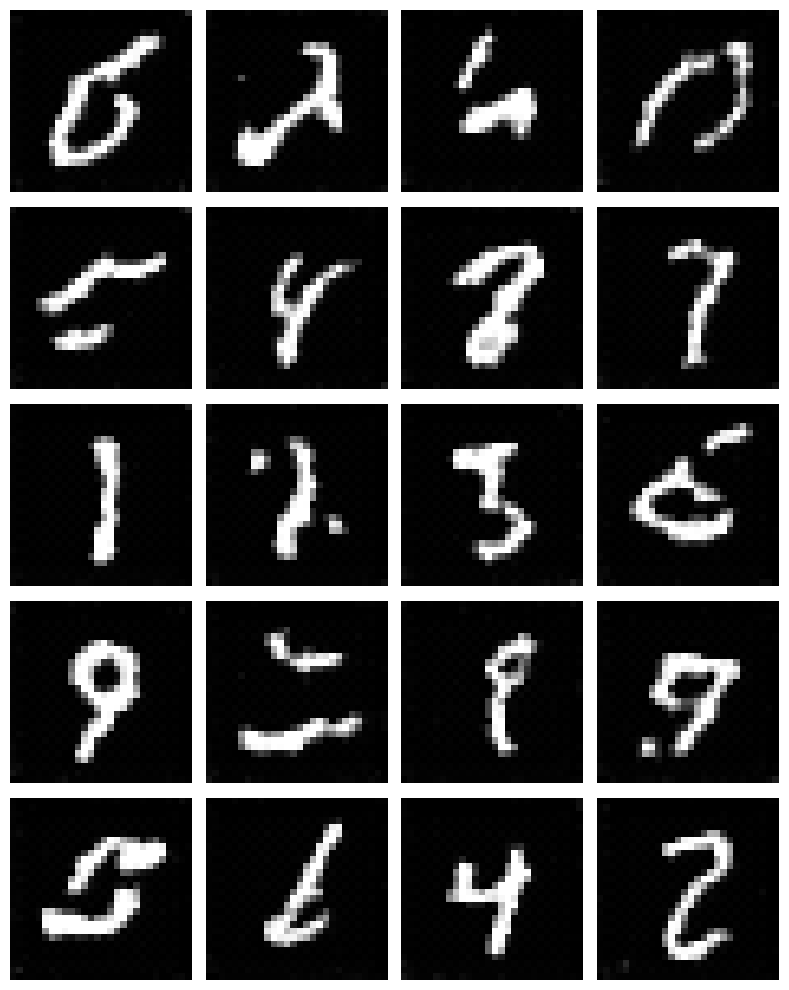

In [ ]:
import matplotlib.pyplot as plt

samples = sample_reverse_process(diffusion_c, model_c, 20)
samples = samples.cpu().squeeze()

fig, axs = plt.subplots(5, 4, figsize=(8, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(samples[i], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
mu_pop = np.mean(test_data.cpu().numpy().reshape(len(test_data), -1), axis=0)
sigma_pop = np.cov(test_data.cpu().numpy().reshape(len(test_data), -1), rowvar=False)

samples = sample_reverse_process(diffusion_c, model_c, batch_size=1000)
samples = samples.cpu().numpy().reshape(1000, -1)
samples.astype(np.float32)

mu_gen = np.mean(samples, axis=0)
sigma_gen = np.cov(samples, rowvar=False)

fid_score = fid(mu_pop, sigma_pop, mu_gen, sigma_gen)
print(f"FID score: {fid_score}")

FID score: 5.7456810222031205


# Code II

## 1

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from torch.nn import functional as F
from torch.optim.lr_scheduler import LambdaLR

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ScoreNet2(nn.Module):
    def __init__(self, channels=[32, 64, 128, 256], embed_dim=256, group_num=4):
        super().__init__()
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))

        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(group_num, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(group_num, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(group_num, num_channels=channels[2])

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(group_num, num_channels=channels[3])

        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(group_num, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(group_num, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(group_num, num_channels=channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)

    def forward(self, x, t):
        embed = self.act(self.embed(t))

        eps1 = self.conv1(x)
        eps1 += self.dense1(embed)
        eps1 = self.gnorm1(eps1)
        eps1 = self.act(eps1)

        eps2 = self.conv2(eps1)
        eps2 += self.dense2(embed)
        eps2 = self.gnorm2(eps2)
        eps2 = self.act(eps2)

        eps3 = self.conv3(eps2)
        eps3 += self.dense3(embed)
        eps3 = self.gnorm3(eps3)
        eps3 = self.act(eps3)

        eps4 = self.conv4(eps3)
        eps4 += self.dense4(embed)
        eps4 = self.gnorm4(eps4)
        eps4 = self.act(eps4)

        eps = self.tconv4(eps4)
        eps += self.dense5(embed)
        eps = self.tgnorm4(eps)
        eps = self.act(eps)

        eps = self.tconv3(torch.cat([eps, eps3], dim=1))
        eps += self.dense6(embed)
        eps = self.tgnorm3(eps)
        eps = self.act(eps)

        eps = self.tconv2(torch.cat([eps, eps2], dim=1))
        eps += self.dense7(embed)
        eps = self.tgnorm2(eps)
        eps = self.act(eps)

        eps = self.tconv1(torch.cat([eps, eps1], dim=1))

        return eps

class Diffusion2(nn.Module):
    def __init__(self, model, n_steps, device, min_beta=0.0001, max_beta=0.02):
        # Store beta, alpha and \bar alpha.
        super().__init__()
        self.model = model
        self.n_steps = n_steps
        self.device = device

        self.beta = torch.linspace(min_beta, max_beta, n_steps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0).to(device)

    def forward_process(self, x0, t):
        # Sample x_{t-1},x_t given x_0
        alpha_bar_tm1 = self.alpha_bar[t - 1].view(-1, 1, 1, 1)
        alpha_t = self.alpha[t].view(-1, 1, 1, 1)
        alpha_bar_t = self.alpha_bar[t].view(-1, 1, 1, 1)

        noise1 = torch.randn_like(x0)
        x_tm1 = torch.sqrt(alpha_bar_tm1) * x0 + torch.sqrt(1 - alpha_bar_tm1) * noise1

        noise2 = torch.randn_like(x0)
        x_t = torch.sqrt(alpha_t) * x_tm1 + torch.sqrt(1 - alpha_t) * noise2
        return x_tm1, x_t

    def predict_next(self, x_t, t):
        # Compute mu(xt,t)
        return self.model(x_t, t)

    def sample_xt_given_x0(self, x0, t):
        alpha_bar_t = self.alpha_bar[t].view(-1, 1, 1, 1)
        noise = torch.randn_like(x0)
        x_t = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise
        return x_t

def compute_loss2(diffusion, model, x0):
    B = x0.shape[0]
    device = x0.device
    T = diffusion.n_steps
    t = torch.randint(1, T, (B,), device=device)
    epsilon = torch.randn_like(x0)

    alpha_t = diffusion.alpha[t].view(B, 1, 1, 1)
    alpha_bar_t = diffusion.alpha_bar[t].view(B, 1, 1, 1)

    x_t = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * epsilon

    eps_pred = model(x_t, t)

    weight = (1 - alpha_t) / (2 * alpha_t * (1 - alpha_bar_t))
    loss = weight.view(B) * ((epsilon - eps_pred) ** 2).view(B, -1).mean(dim=1)
    return loss.mean()

def train_code2(model, diffusion, train_data, val_data, optimizer, loss_fn, num_epochs=60, batch_size=100):
    device = diffusion.device
    train_dataset = torch.utils.data.TensorDataset(train_data)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = torch.utils.data.TensorDataset(val_data)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for (x0_batch,) in train_loader:
            x0 = x0_batch.to(device)

            optimizer.zero_grad()
            loss = loss_fn(diffusion, model, x0)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (x0_batch,) in val_loader:
                x0 = x0_batch.to(device)
                loss = loss_fn(diffusion, model, x0)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

In [ ]:
train_data, val_data, test_data = get_mnist()

model = ScoreNet2().to(device)
diffusion = Diffusion2(model, n_steps=200, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_code2(model, diffusion, train_data, val_data, optimizer, compute_loss2, num_epochs=100)

Epoch 1, Train Loss: 0.01738809134811163, Val Loss: 0.01081402603769675
Epoch 2, Train Loss: 0.010226392120588571, Val Loss: 0.0100587550830096
Epoch 3, Train Loss: 0.008896564358379691, Val Loss: 0.007421897421590984
Epoch 4, Train Loss: 0.006071869387757033, Val Loss: 0.004922879147343338
Epoch 5, Train Loss: 0.004975866341032088, Val Loss: 0.004616801892407239
Epoch 6, Train Loss: 0.004177857598988339, Val Loss: 0.0040808379964437334
Epoch 7, Train Loss: 0.0033995047614444047, Val Loss: 0.0031415442563593387
Epoch 8, Train Loss: 0.0031029752988833933, Val Loss: 0.0029722211568150667
Epoch 9, Train Loss: 0.0028556813031900673, Val Loss: 0.004636967942351475
Epoch 10, Train Loss: 0.0031626534138340504, Val Loss: 0.00280512121738866
Epoch 11, Train Loss: 0.002587103643454611, Val Loss: 0.0027243248035665603
Epoch 12, Train Loss: 0.002623216218315065, Val Loss: 0.002291754926554859
Epoch 13, Train Loss: 0.0089852963257581, Val Loss: 0.006209969168994575
Epoch 14, Train Loss: 0.004459881

## 2

In [ ]:
@torch.no_grad()
def sample2(diffusion, model, batch_size):
    model.eval()
    device = diffusion.device
    T = diffusion.n_steps
    x_t = torch.randn((batch_size, 1, 28, 28), device=device)

    for t in reversed(range(0, T)):
        t_tensor = torch.full((batch_size,), t, dtype=torch.long, device=device)

        alpha_t = diffusion.alpha[t].view(1, 1, 1, 1)
        alpha_bar_t = diffusion.alpha_bar[t].view(1, 1, 1, 1)

        eps_pred = model(x_t, t_tensor)

        coef1 = 1 / torch.sqrt(alpha_t)
        coef2 = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)
        mu = coef1 * (x_t - coef2 * eps_pred)

        if t > 0:
            noise = torch.randn_like(x_t)
            x_t = mu + torch.sqrt(1-alpha_t) * noise
        else:
            x_t = mu.clamp(0, 1)

    return x_t


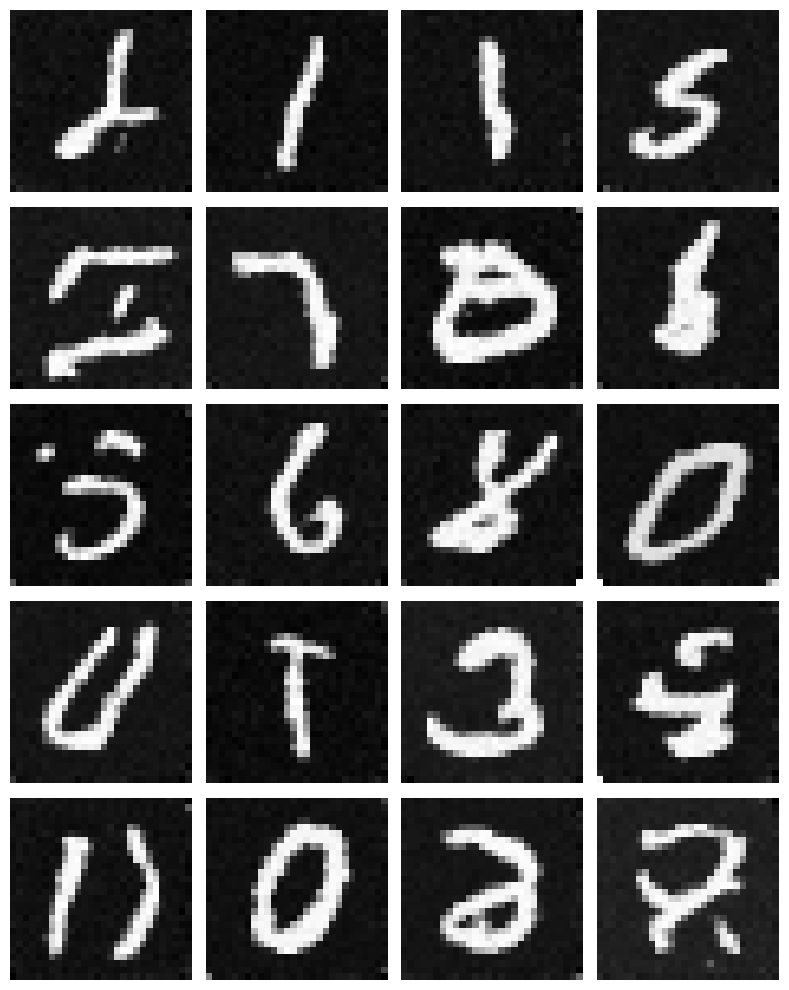

In [ ]:
import matplotlib.pyplot as plt

samples = sample2(diffusion, model, 20)
samples = samples.cpu().squeeze()

fig, axs = plt.subplots(5, 4, figsize=(8, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(samples[i], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
mu_pop = np.mean(test_data.cpu().numpy().reshape(len(test_data), -1), axis=0)
sigma_pop = np.cov(test_data.cpu().numpy().reshape(len(test_data), -1), rowvar=False)

samples = sample2(diffusion, model, batch_size=1000)
samples = samples.cpu().numpy().reshape(1000, -1)

mu_gen = np.mean(samples, axis=0)
sigma_gen = np.cov(samples, rowvar=False)

fid_score = fid(mu_pop, sigma_pop, mu_gen, sigma_gen)
print(f"FID score: {fid_score}")

FID score: 4.729483984811327


## 3
The FID score for the second version of the model has a slightly lower FID, but the samples still look pretty similar. Some of the samples look like digits while others have loops or disconected strokes.